This purpose of this notebook is to automatically identify which features are highly correlated with each other and systematically remove them

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import networkx as nx

NSCH19 = pd.read_sas("data/nsch_2019e_topical.sas7bdat")

from sklearn.model_selection import train_test_split
from NSCH_helpers import impute_NSCH, clean_NSCH

In [60]:
# Defining the cleaned data set.  We drop columns that don't make sense to investigate correlation with.

clean_NSCH19 = clean_NSCH(NSCH19)
drop_cols = ['STATE', 'ABBR', 'FIPSST', 'days_missed']
clean_NSCH19 = clean_NSCH19.drop(drop_cols, axis = 1)

In [61]:
# This creates a serise with values equal to the correlation of the multiindex of a pair of features.  
# Note that the absolute value of the correlation is considered.  We remove instances of pairs with the same feature by only looking at
# correlation values of < 1.
corr_series = clean_NSCH19.corr().unstack()
corr_series = corr_series.loc[corr_series < 1]
corr_series = corr_series.apply(abs)
corr_series = corr_series.sort_values()


In [62]:
# This creates a new multi-index which is sorted.  This will help in removing duplicates.
new_index = pd.MultiIndex.from_tuples([tuple(sorted(pair)) for pair in corr_series.index], names=corr_series.index.names)
# This reassigns the index of corr_series
corr_series.index = new_index
# This removes duplicate indices
corr_series =corr_series[~corr_series.index.duplicated(keep = 'first')]

In [63]:
# This creates a series with high correlation as defined by threshold
threshold = 0.8
high_corr_series = corr_series[corr_series.values >= threshold]

## Visualizing Correlated Features

We will visualize correlation via a weighted graph.

In [84]:
# Creating the edges (indices) and weights (correlations)
weights = [round(corr,2) for corr in high_corr_series.values]
edges = [index for index in high_corr_series.index]
edges_with_weights = list(zip(edges, weights))

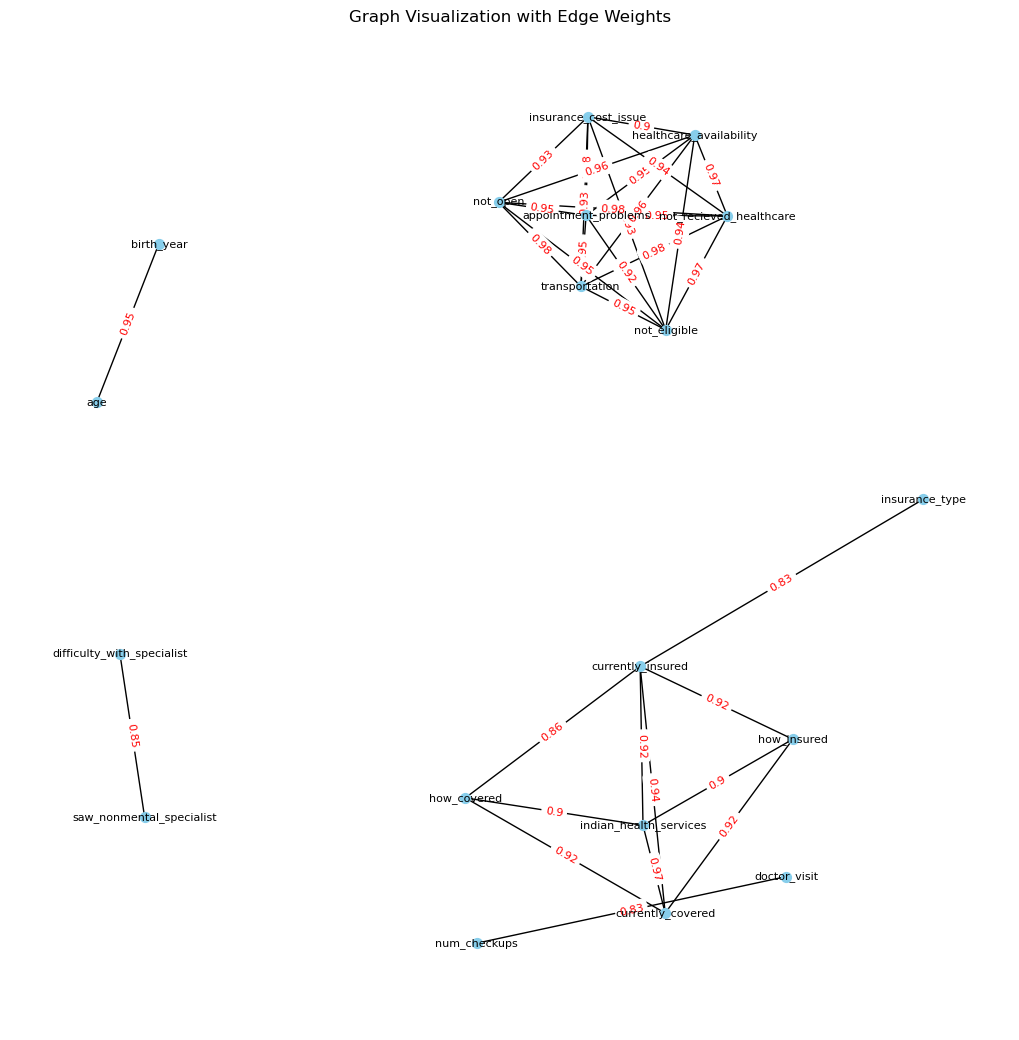

In [98]:
# This creates a graph from our edge_with_weights and visuializes the graph.
G = nx.Graph()

for edge, weight in edges_with_weights:
    G.add_edge(edge[0], edge[1], weight=weight)

pos = nx.spring_layout(G, k=1)
plt.figure(figsize=(10,10))
nx.draw(G, pos, with_labels=True, node_size=50, node_color='skyblue', font_size=8)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color='r')

plt.title("Graph Visualization with Edge Weights")
plt.show()
